# House Price Predictor

The purpose of this model is to use Kaggle's dataset about homes in Ames, Iowa and their associated prices to develop a linear regression model that accurately predicts the price of a home based on 79 explanatory variables.

### Data Exploration

In [281]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [282]:
# import dataset
X = pd.read_csv('data/train.csv')
y = pd.read_csv('data/test.csv')

In [283]:
# display X and y shape
print(f'Training Data Shape: {X.shape}')
print(f'Test Data Shape: {y.shape}')

Training Data Shape: (1460, 81)
Test Data Shape: (1459, 80)


In [284]:
# display X data sample
X.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Text(0.5, 1.0, 'X Null Values')

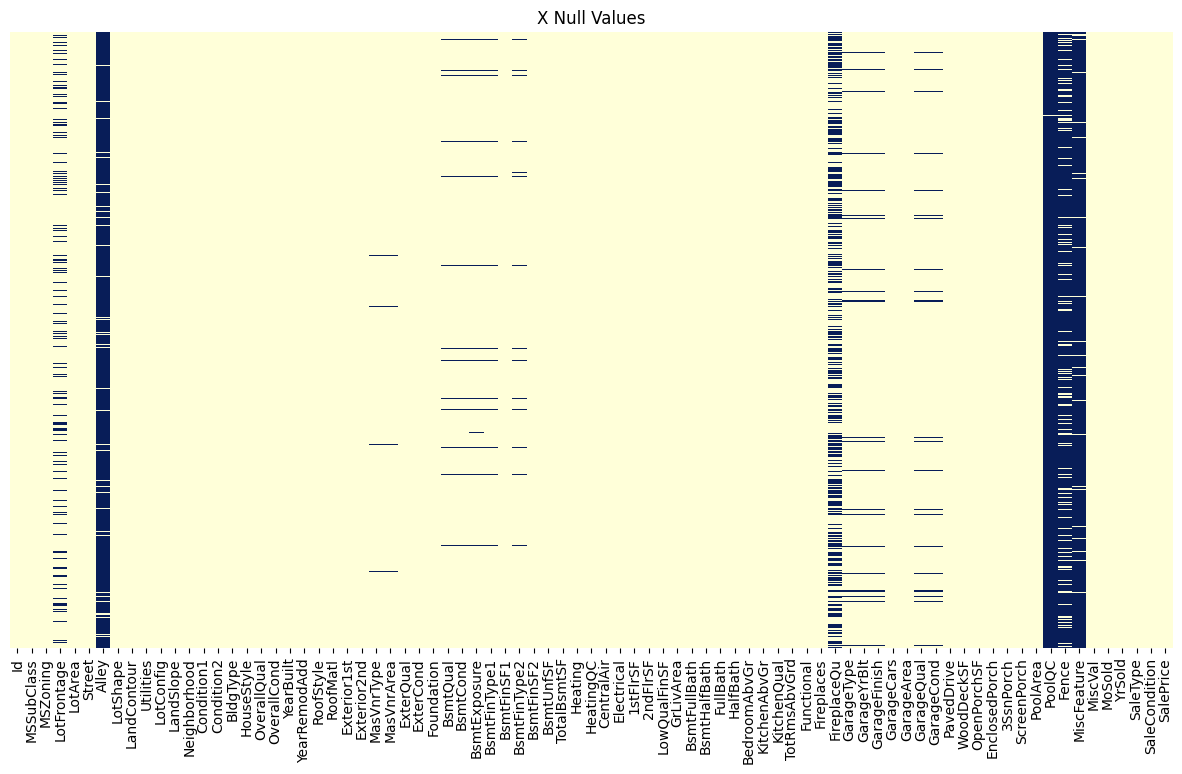

In [285]:
# plot X null values
plt.figure(figsize=(15, 8))
sns.heatmap(X.isnull(), yticklabels=False, cbar=False, cmap='YlGnBu')
plt.title('X Null Values')

In [286]:
# display count of X null values
print('X Null Values (Descending)')
X.isnull().sum().sort_values(ascending=False)

X Null Values (Descending)


PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

In [287]:
# display null column values in y that are not in X
X_null_cols = X.columns[X.isnull().any()].tolist()
y_null_cols = y.columns[y.isnull().any()].tolist()
print(f'Column                | Null Count')
print('-------------------------------------')
for col in y_null_cols:
    if col not in set(X_null_cols):
        null_count = y[col].isnull().sum()
        print(f'{col:<22}| {null_count:>11}')

Column                | Null Count
-------------------------------------
MSZoning              |           4
Utilities             |           2
Exterior1st           |           1
Exterior2nd           |           1
BsmtFinSF1            |           1
BsmtFinSF2            |           1
BsmtUnfSF             |           1
TotalBsmtSF           |           1
BsmtFullBath          |           2
BsmtHalfBath          |           2
KitchenQual           |           1
Functional            |           2
GarageCars            |           1
GarageArea            |           1
SaleType              |           1


Text(0.5, 1.0, 'X Correlation Matrix')

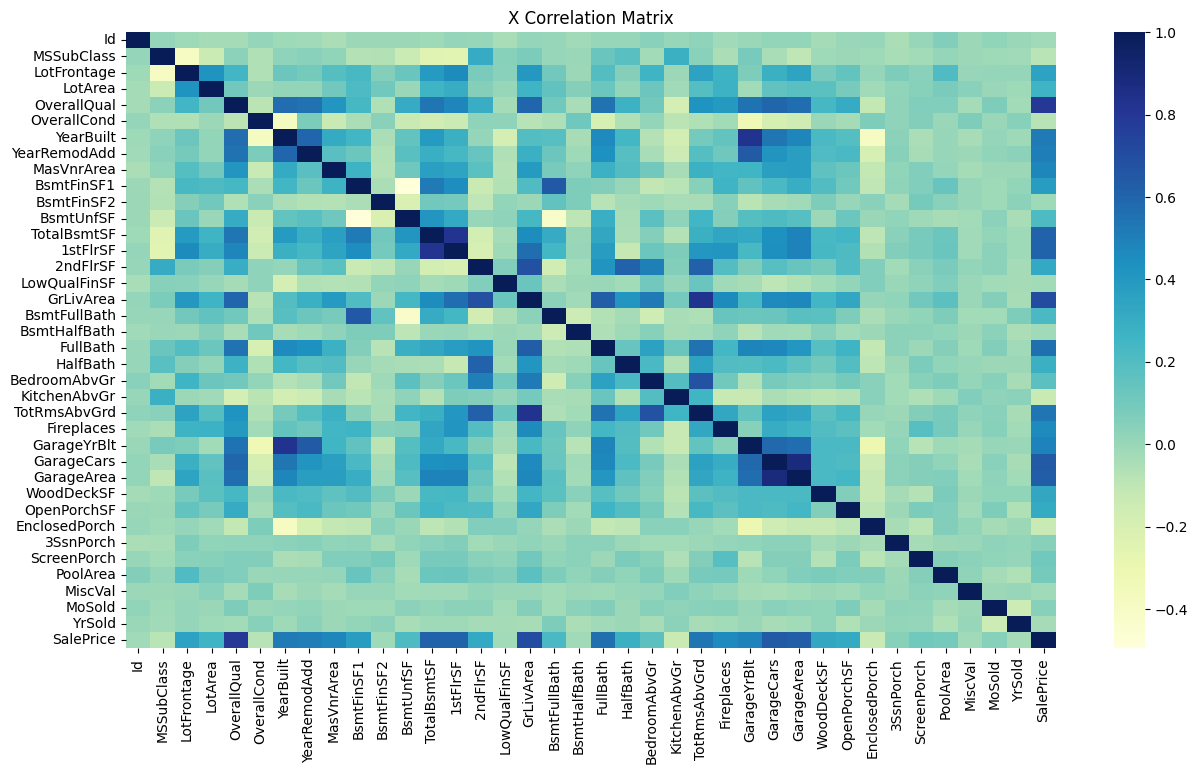

In [288]:
# plot X correlation matrix
plt.figure(figsize=(15, 8))
sns.heatmap(X.corr(numeric_only=True), cmap='YlGnBu')
plt.title('X Correlation Matrix')

In [289]:
# display correlation between X and SalePrice
print('Correlation between X and SalePrice:')
X.corrwith(X['SalePrice'], numeric_only=True).sort_values(ascending=False)

Correlation between X and SalePrice:


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
dtype: float

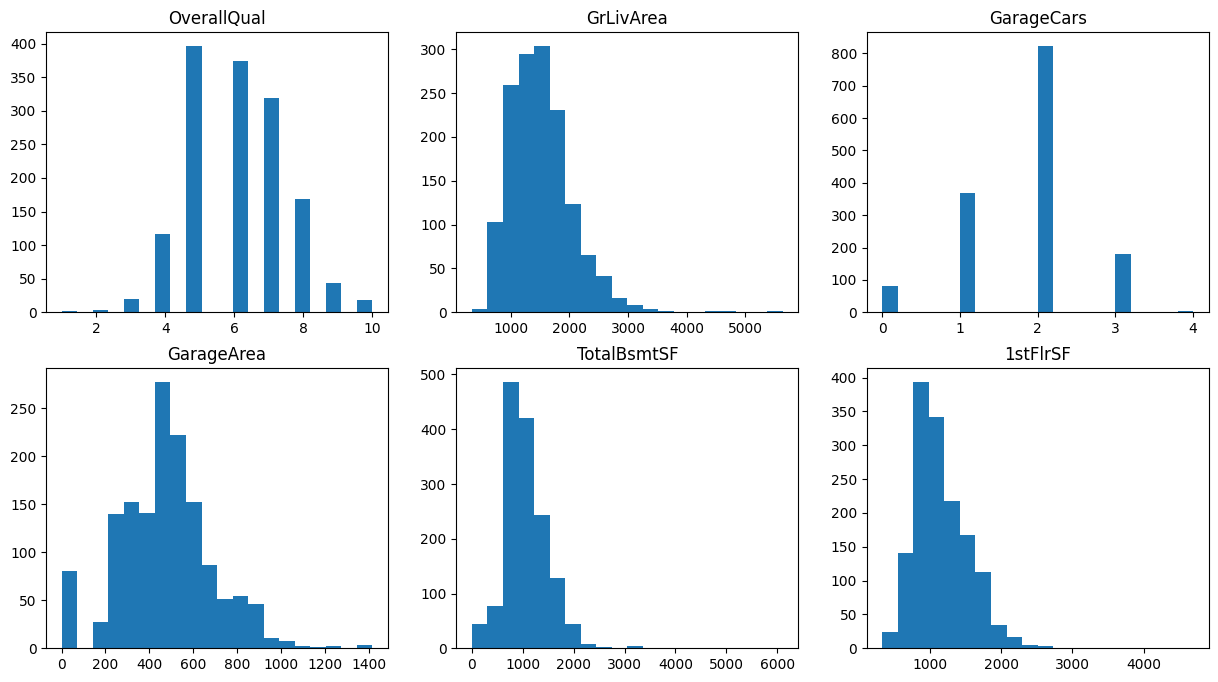

In [290]:
# Find the 6 columns with highest correlations to X['SalePrice']
corr = X.corrwith(X['SalePrice'], numeric_only=True).abs().sort_values(ascending=False)
top6_cols = corr[1:7].index.tolist()

# Plot histograms of the top 6 columns
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
for i, col in enumerate(top6_cols):
    ax = axs[i // 3, i % 3]
    ax.hist(X[col], bins=20)
    ax.set_title(col)
plt.show()

### Data Preprocessing

In [291]:
# delete columns with over 25% null values
null_percentages = X.isnull().sum() / X.shape[0]
null_columns = null_percentages[null_percentages > 0.25].index.tolist()
X = X.drop(null_columns, axis=1)
y = y.drop(null_columns, axis=1)

In [292]:
# replace remaining nulls with mean (quantitative data) or mode (qualitative data)
for col in X.drop('SalePrice', axis=1).columns:
    # quantitative data
    if pd.api.types.is_numeric_dtype(X[col]):
        X[col].fillna(X[col].mean(), inplace=True)
        y[col].fillna(X[col].mean(), inplace=True)
    # qualitative data
    else:
        X[col].fillna(X[col].mode()[0], inplace=True)
        y[col].fillna(X[col].mode()[0], inplace=True)

In [293]:
# replace qualitative columns with dummies
X = pd.get_dummies(X)
y = pd.get_dummies(y)
X, y = X.align(y, join='outer', axis=1, fill_value=0)
y.drop('SalePrice', axis=1, inplace=True)

In [294]:
# review data after changes
print(f'X shape: {X.shape}')
print('X data sample: ')
X.head()

X shape: (1460, 272)
X data sample: 


,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Fa,...,Street_Grvl,Street_Pave,TotRmsAbvGrd,TotalBsmtSF,Utilities_AllPub,Utilities_NoSeWa,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,3,1,0,0,0,0,0,...,0,1,8,856,1,0,0,2003,2003,2008
1,1262,0,0,3,1,0,0,0,0,0,...,0,1,6,1262,1,0,298,1976,1976,2007
2,920,866,0,3,1,0,0,0,0,0,...,0,1,6,920,1,0,0,2001,2002,2008
3,961,756,0,3,1,0,0,0,0,0,...,0,1,7,756,1,0,0,1915,1970,2006
4,1145,1053,0,4,1,0,0,0,0,0,...,0,1,9,1145,1,0,192,2000,2000,2008


In [295]:
# review correlation between X and SalePrice
print('Correlation between X and SalePrice:')
X.corrwith(X['SalePrice']).sort_values(ascending=False)

Correlation between X and SalePrice:


SalePrice           1.000000
OverallQual         0.790982
GrLivArea           0.708624
GarageCars          0.640409
GarageArea          0.623431
                      ...   
MasVnrType_None    -0.367456
BsmtQual_TA        -0.498545
GarageFinish_Unf   -0.513906
KitchenQual_TA     -0.519298
ExterQual_TA       -0.589044
Length: 272, dtype: float64

### Feature Engineering

In [296]:
# drop columns with absolute correlation <MIN_CORR
MIN_CORR = 0.32  # set value here

cols_to_drop = []
abs_corrs = X.corrwith(X['SalePrice']).abs()
for i, ac in enumerate(abs_corrs):
    if ac < MIN_CORR:
        cols_to_drop.append(X.columns[i])
X.drop(cols_to_drop, axis=1, inplace=True)
y.drop(cols_to_drop, axis=1, inplace=True)

Text(0.5, 1.0, 'X Correlation Matrix')

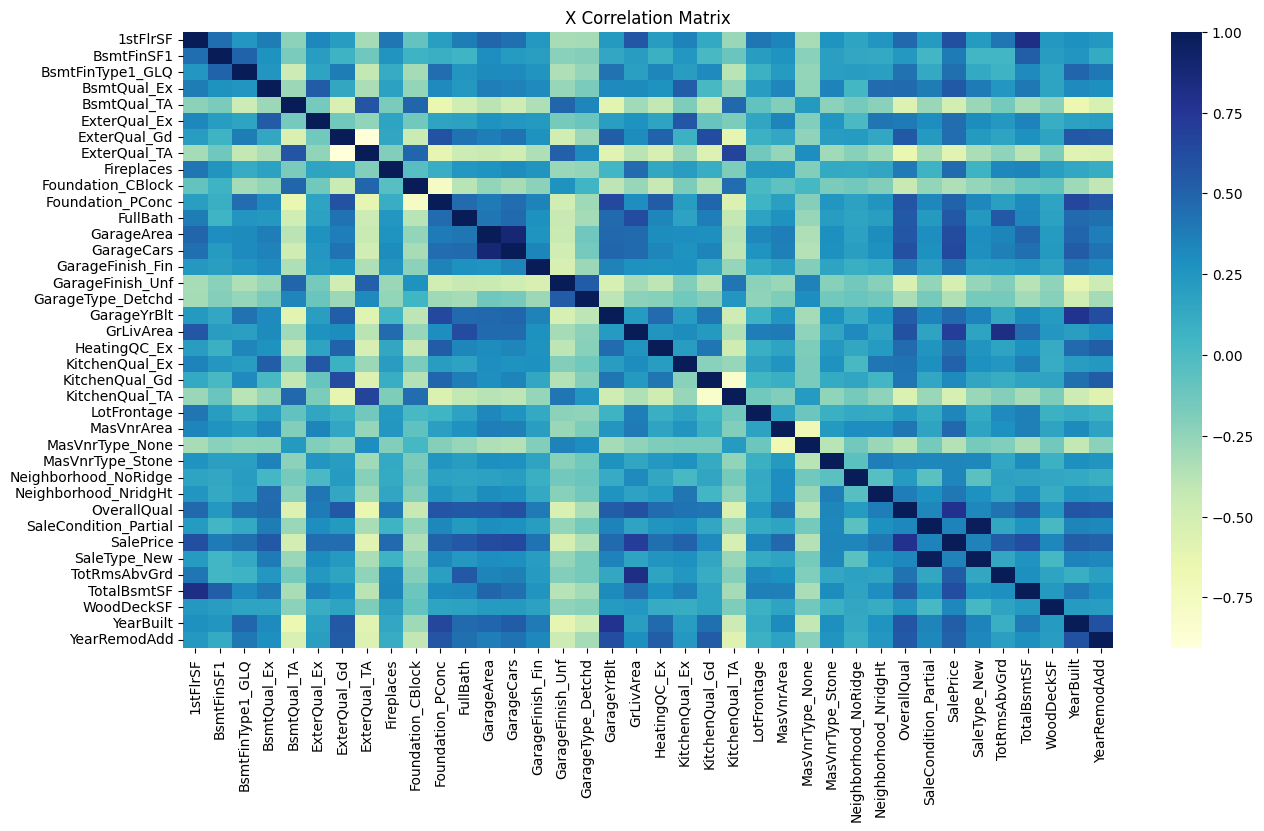

In [297]:
# review plot of X correlation matrix
plt.figure(figsize=(15, 8))
sns.heatmap(X.corr(), cmap='YlGnBu')
plt.title('X Correlation Matrix')

### Model Training

In [298]:
# split X and y into training and testing sets
X_train = X.drop('SalePrice', axis=1)
y_train = X['SalePrice']

In [299]:
# fit linear regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Model Evaluation

In [300]:
# use model to predict SalePrice for test data
y_pred = pd.DataFrame(model.predict(y))
y_pred.columns = ['SalePrice']
y_pred.head()

,SalePrice
0,113711.600037
1,155548.929860
2,177681.461548
3,193710.336974
4,194087.933176


In [301]:
# prepare predictions for submissions
sample = pd.read_csv('data/sample_submission.csv')
submission = pd.concat([sample['Id'], y_pred], axis=1)
submission.head()


,Id,SalePrice
0,1461,113711.600037
1,1462,155548.929860
2,1463,177681.461548
3,1464,193710.336974
4,1465,194087.933176


In [302]:
# import expected data

expected = pd.read_csv('data/expected.csv')
expected.head()

,Id,SalePrice
0,1461,105000.0
1,1462,172000.0
2,1463,189900.0
3,1464,195500.0
4,1465,191500.0


In [303]:
# calculate RSME as done on Kaggle
from sklearn.metrics import mean_squared_error

y_pred_log = np.log(y_pred['SalePrice'])
expected_log = np.log(expected['SalePrice'])

rmse_log = np.sqrt(mean_squared_error(expected_log, y_pred_log))
print("Root Mean Squared Error (RMSE):", rmse_log)


Root Mean Squared Error (RMSE): 0.16051916854965412


In [304]:
# calculate R2 score
from sklearn.metrics import r2_score

r2 = r2_score(expected['SalePrice'], y_pred['SalePrice'])
print("R-squared (R2) Score:", r2)


R-squared (R2) Score: 0.8717717336521469


In [305]:
# export submission
submission.to_csv('submission.csv', index=False)